In [9]:
using ViscousFlow

In [10]:
using Plots
pyplot()
default(grid = false)

In [11]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

In [12]:
xlim = (-1.0,3.0)
ylim = (-1.0,1.0)

Δx, Δt = setstepsizes(Re)

(0.01, 0.005)

In [13]:
body = Plate(1.0,1.5Δx)

Plate with 66 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [15]:
#body = NACA4(0.0,0.0,0.12,1.5Δx)

In [16]:
cent = (0.0,0.0)
α = 40π/180 #π/3 #π/4
T = RigidTransform(cent,-α)
T(body) # transform the body to the current configuration

Plate with 66 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): -0.6981317007977318


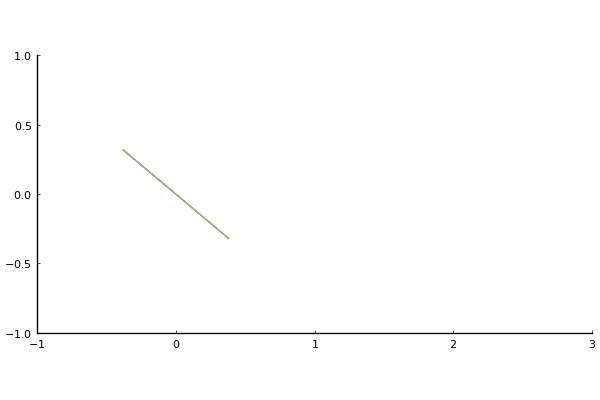

In [17]:
plot(body,xlim=xlim,ylim=ylim)

In [18]:
X = VectorData(collect(body));

In [19]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 416 x 208

In [20]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);
xg, yg = coordinates(w₀,dx=cellsize(sys),I0=origin(sys))

(-1.075:0.01:3.075, -1.035:0.01:1.035)

In [21]:
plan_intfact(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
r₁(u,t) = ConstrainedSystems.r₁(u,t,sys)
r₂(u,t) = ConstrainedSystems.r₂(u,t,sys)


@time solver = IFHERK(w₀,f,timestep(sys),plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

 14.260098 seconds (20.06 M allocations: 3.126 GiB, 4.70% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,416,208,Float64,Array{Float64,2}}
   Force of type VectorData{66,Float64,Array{Float64,1}}
   Time step size 0.005


In [22]:
u = zero(w₀)

# Rate at which to store field data
tsample = 0.2

# Field data storage plan
S = StorePlan(tsample,"state"=>u,"time"=>t)
data_history = initialize_storage(S)

# Force data storage plan, stored every time step
F = StorePlan(timestep(sys),"fx"=>sum(f.u),"fy"=>sum(f.v),"time"=>t)
force_history = initialize_storage(F)
nothing

LoadError: UndefVarError: t not defined

In [23]:
t = 0.0
u = zero(w₀)

# Rate at which to store field data
tsample = 0.2

# Field data storage plan
S = StorePlan(tsample,"state"=>u,"time"=>t)
data_history = initialize_storage(S)

# Force data storage plan, stored every time step
F = StorePlan(timestep(sys),"fx"=>sum(f.u),"fy"=>sum(f.v),"time"=>t)
force_history = initialize_storage(F)
nothing

In [24]:
tsim = 1.0;

In [25]:
for ti in timerange(tsim,sys)
    global t, u, f = solver(t,u)
    
    fds = force(f,sys) 
    
    store_data!(data_history,t,S,"state" => u, "time" => t)
    store_data!(force_history,t,F,"fx" => sum(fds.u),"fy" => sum(fds.v),"time" => t)
    
 end
println("solution completed through time t = ",t)

solution completed through time t = 1.0000000000000007


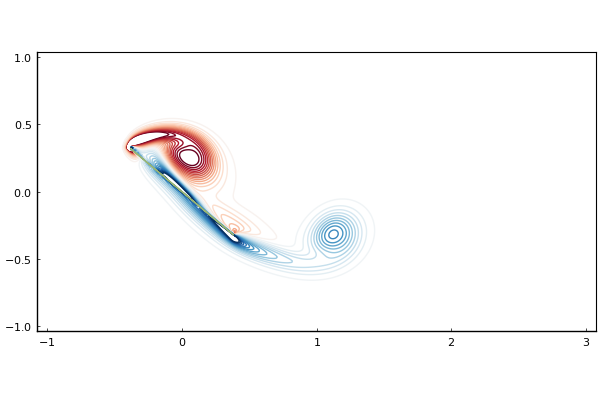

In [26]:
plot(xg,yg,vorticity(data_history["state"][end],sys),levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15))
plot!(body)

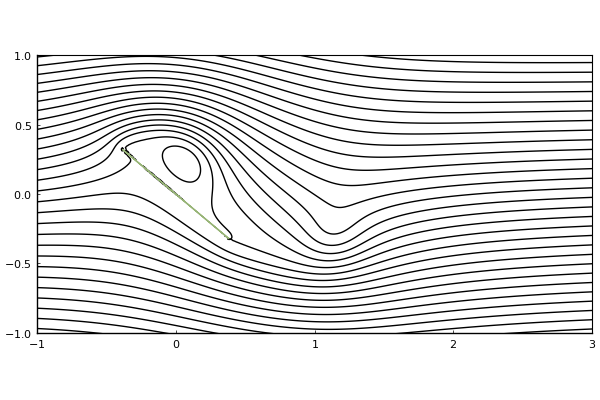

In [27]:
plot(xg,yg,streamfunction(data_history["state"][end],sys),levels=range(-1,1,length=31), color = :black,clim=(-0.25,0.25),xlim=(-1,3),ylim=(-1,1))
plot!(body)

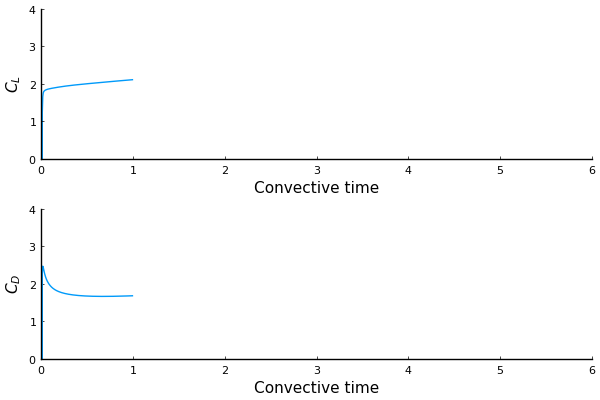

In [28]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],force_history["time"],2*force_history["fy"],xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],force_history["time"],2*force_history["fx"],xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt